In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


In [2]:
labels = ['hack','not_hack']

In [132]:
seed = 44

In [4]:
df_train = pd.read_csv('Scaled_train_data.csv')

In [5]:
df_train.shape

(23856, 18)

In [6]:
df_train.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MONTH,YEAR,MULTIPLE_OFFENSE
0,-0.336018,0.735474,0.618599,-0.773174,-0.741487,-0.258103,0.289416,0.018952,0.789559,-0.21871,-0.354223,0.022125,0.245047,-1.008707,0.302290,0.149115,-0.031958,0
1,0.358553,0.801090,0.816814,-1.452367,-1.250886,1.083651,3.123057,0.018952,0.789559,-0.21871,0.312205,0.022125,0.643638,1.601155,0.063821,0.149115,1.635738,1
2,-0.336018,-1.429847,-1.495693,-0.433578,1.296112,-1.152606,-1.256207,0.707115,-1.412075,-0.21871,-0.354223,0.022125,0.897286,0.469445,0.063821,-1.065287,1.635738,1
3,-0.336018,0.538627,0.486456,-0.773174,-0.741487,0.189148,-0.998603,0.018952,0.789559,-0.21871,0.451940,0.022125,-0.479664,-1.008707,0.063821,-1.368887,0.609464,1
4,-0.336018,0.538627,0.486456,-0.773174,-0.741487,0.412774,-0.483396,-0.669211,0.055681,-0.21871,-0.354223,-0.837524,0.969758,-1.008707,1.136931,-0.761686,0.096326,1


In [7]:
hack = df_train[df_train['MULTIPLE_OFFENSE']==0]
not_hack = df_train[df_train['MULTIPLE_OFFENSE']==1]

In [235]:
hack.shape

(1068, 18)

In [236]:
not_hack.shape

(22788, 18)

In [12]:

# data = df_train.drop(['DATE','INCIDENT_ID'], axis=1)
data = df_train

In [13]:
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MONTH,YEAR,MULTIPLE_OFFENSE
0,-0.336018,0.735474,0.618599,-0.773174,-0.741487,-0.258103,0.289416,0.018952,0.789559,-0.21871,-0.354223,0.022125,0.245047,-1.008707,0.302290,0.149115,-0.031958,0
1,0.358553,0.801090,0.816814,-1.452367,-1.250886,1.083651,3.123057,0.018952,0.789559,-0.21871,0.312205,0.022125,0.643638,1.601155,0.063821,0.149115,1.635738,1
2,-0.336018,-1.429847,-1.495693,-0.433578,1.296112,-1.152606,-1.256207,0.707115,-1.412075,-0.21871,-0.354223,0.022125,0.897286,0.469445,0.063821,-1.065287,1.635738,1
3,-0.336018,0.538627,0.486456,-0.773174,-0.741487,0.189148,-0.998603,0.018952,0.789559,-0.21871,0.451940,0.022125,-0.479664,-1.008707,0.063821,-1.368887,0.609464,1
4,-0.336018,0.538627,0.486456,-0.773174,-0.741487,0.412774,-0.483396,-0.669211,0.055681,-0.21871,-0.354223,-0.837524,0.969758,-1.008707,1.136931,-0.761686,0.096326,1


In [237]:
X_train, X_test = train_test_split(data, test_size=0.10, random_state=seed)
X_train = X_train[X_train.MULTIPLE_OFFENSE == 1]
X_train = X_train.drop(['MULTIPLE_OFFENSE'], axis=1)
y_test = X_test['MULTIPLE_OFFENSE']
X_test = X_test.drop(['MULTIPLE_OFFENSE'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(20510, 17)

In [238]:
len(X_test)

2386

In [239]:
y_test.value_counts()

1    2278
0     108
Name: MULTIPLE_OFFENSE, dtype: int64

## using 1 layer autoencoder 

In [393]:
input_dim = X_train.shape[1]
encoding_dim = 16
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu")(input_layer)    #activity_regularizer=regularizers.l1(10e-5)
decoder = Dense(encoding_dim , activation='relu')(encoder)
decoder = Dense(input_dim )(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [394]:
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 17)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 16)                288       
_________________________________________________________________
dense_80 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_81 (Dense)             (None, 17)                289       
Total params: 849
Trainable params: 849
Non-trainable params: 0
_________________________________________________________________


In [395]:
nb_epoch = 20
batch_size = 64
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="scaled_features/model_1_layer_encoder_try1.pt",
                               verbose=0,
                               save_best_only=True)

In [396]:
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer]).history

Train on 20510 samples, validate on 2386 samples
Epoch 1/20
20510/20510 [==============================] - 0s 18us/step - loss: 0.7802 - accuracy: 0.2246 - val_loss: 0.4780 - val_accuracy: 0.3701
Epoch 2/20
20510/20510 [==============================] - 0s 16us/step - loss: 0.3817 - accuracy: 0.4489 - val_loss: 0.2395 - val_accuracy: 0.4950
Epoch 3/20
20510/20510 [==============================] - 0s 16us/step - loss: 0.2059 - accuracy: 0.5610 - val_loss: 0.1312 - val_accuracy: 0.6287
Epoch 4/20
20510/20510 [==============================] - 0s 17us/step - loss: 0.1121 - accuracy: 0.6593 - val_loss: 0.0702 - val_accuracy: 0.7184
Epoch 5/20
20510/20510 [==============================] - 0s 15us/step - loss: 0.0627 - accuracy: 0.7361 - val_loss: 0.0441 - val_accuracy: 0.7687
Epoch 6/20
20510/20510 [==============================] - 0s 15us/step - loss: 0.0420 - accuracy: 0.7893 - val_loss: 0.0308 - val_accuracy: 0.7992
Epoch 7/20
20510/20510 [==============================] - 0s 16us/ste

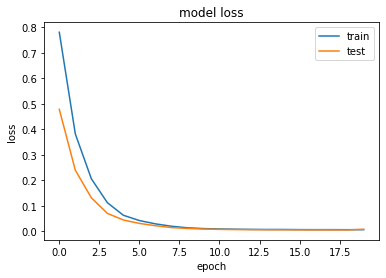

In [397]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [398]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,2386.000000,2386.000000
mean,0.007841,0.954736
std,0.042657,0.207926
min,0.000099,0.000000
25%,0.000807,1.000000
50%,0.001645,1.000000
75%,0.007288,1.000000
max,1.866727,1.000000


## Reconstruction error without Fraud

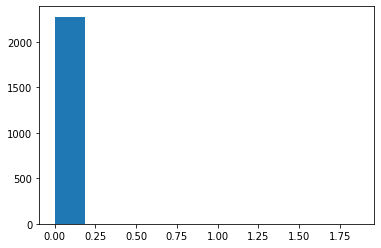

In [399]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 1) ]   #& (error_df['reconstruction_error'] < 10)
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with Fraud

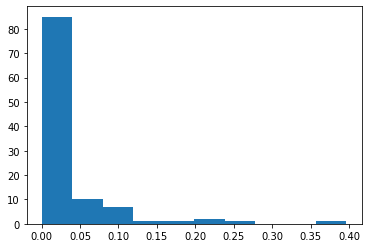

In [400]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 0]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [401]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

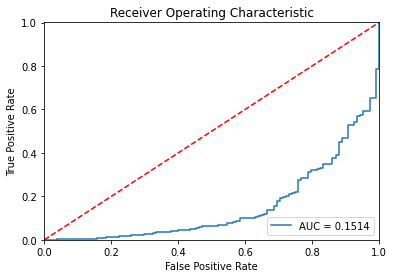

In [402]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

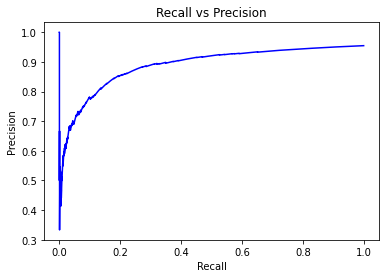

In [403]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

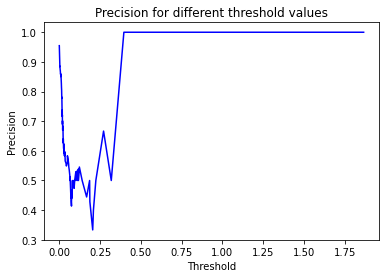

In [404]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

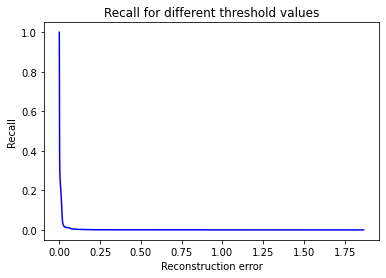

In [405]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [406]:
error_df.head()

,reconstruction_error,true_class
8972,0.000420,1
22053,0.016387,1
12560,0.016874,0
808,0.396182,0
11193,0.002867,0


In [407]:
error_df[error_df['true_class']==1]['reconstruction_error'].mean()

0.006490387152127509

In [408]:
error_df[error_df['true_class']==0]['reconstruction_error'].mean()

0.03633369145816173

In [409]:
threshold = error_df[error_df['true_class']==1]['reconstruction_error'].mean()


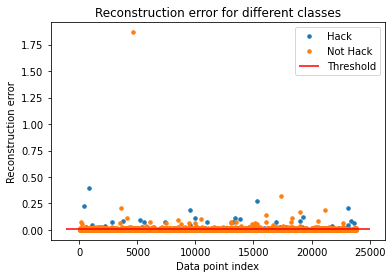

In [410]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Hack" if name == 0 else "Not Hack")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

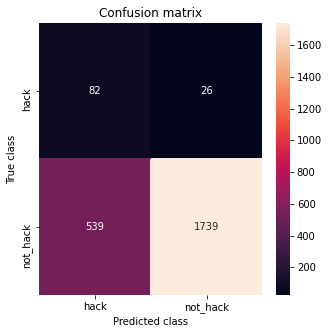

In [411]:
y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels= labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [356]:
from sklearn.metrics import recall_score

In [412]:
recall_score(error_df.true_class, y_pred,pos_label=0)

0.7592592592592593

In [120]:
test_data = pd.read_csv('Scaled_test_data.csv')

In [121]:
test_data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MONTH,YEAR
0,-0.331481,0.346538,0.689141,0.912994,0.280910,-0.019072,-0.223789,-0.670665,0.066372,-0.286542,-0.353935,0.031543,-0.479795,1.076964,-1.253581,-1.385653,1.775280
1,-0.331481,1.265846,1.284086,-1.104095,0.280910,0.205591,-1.002090,2.048068,0.793816,-0.286542,1.171179,-1.113717,-2.662153,-0.994943,0.069444,-1.081162,-0.024625
2,-0.331481,0.609197,0.556931,-0.431732,1.299566,-0.917722,0.554512,1.368384,-3.570845,-0.286542,1.171179,0.031543,-0.479795,-1.662558,0.069444,-1.690145,1.775280
3,4.625633,-1.426414,-1.492323,-0.431732,1.299566,0.654917,0.813946,-0.670665,0.066372,-0.286542,-0.353935,0.031543,0.975111,0.340286,0.069444,0.441295,0.232504
4,-0.331481,-1.163754,-1.095693,0.912994,0.280910,-0.917722,0.554512,0.009018,0.066372,-0.286542,-0.353935,-1.113717,0.975111,0.478413,1.151918,1.050278,0.875328


In [413]:
test_arr = np.array(test_data)

In [414]:
type(test_arr[0])

numpy.ndarray

In [415]:
test_predictions = autoencoder.predict(test_arr)

In [416]:
test_predictions

array([[-0.3337462 ,  0.48166004,  0.55365765, ..., -1.2284131 ,
        -1.3563203 ,  1.7412047 ],
       [-0.32759064,  1.2736095 ,  1.2568347 , ..., -0.00654256,
        -1.0673208 ,  0.01731901],
       [-0.31223273,  0.5671836 ,  0.60005444, ...,  0.06322044,
        -1.6853536 ,  1.7646992 ],
       ...,
       [-0.32437998,  0.07020944,  0.1725187 , ...,  0.084108  ,
        -0.7554884 ,  0.21870713],
       [-0.30154675, -0.17667247, -0.12687719, ...,  0.14147592,
        -0.75479865,  0.5129872 ],
       [-0.32203948, -1.3742616 , -1.3447741 , ...,  0.05654871,
        -0.7473612 , -1.0544045 ]], dtype=float32)

In [417]:
mse_test = np.mean(np.power(test_arr - test_predictions, 2), axis=1)

In [418]:
mse_test

array([0.00539938, 0.0308115 , 0.00309547, ..., 0.00402779, 0.00294892,
       0.0013446 ])

In [419]:
test_pred = [0 if e > threshold else 1 for e in mse_test]

In [420]:
test_pred

[1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,


In [364]:
k = pd.Series(test_pred,name='MULTIPLE_OFFENSE')

In [421]:
k.to_csv('Prediction_folder/pred_75_percent_recall.csv',index=False)